# ImprovedSCIT_2010

- **Paper**: An Improved Storm Cell Identification and Tracking (SCIT) Algorithm based on DBSCAN Clustering and JPDA Tracking Methods.

- $\textbf{\textcolor{red}{Identification}}$:
    - **Identification**:
        + apply multiple thresholds
        + for each threshold, use DBSCAN to detect clusters, each cluster -> a single storm
        + *combining*: only use highest & lowest dbz => inner most are saved with being represented by largest possible area

    - **Representation**:
        + draw a set of particles uniformly inside each storm

- $\textbf{\textcolor{blue}{Tracking}}$:
    - **Estimate motion**:
        + Initially, use the user input estimate motion. Later, use the previous estimated motion 
        + storm => average of user input convex field (initially)
        + subset of storms => the same velocity (later)
        + particle within storm => same velocity

    - **Matching**:
        + *Particles matching*: construct a disparity matrix and apply Hungarian algorithm. The case function between 2 particles includes:
            + displacement between 2 particles in t and t+1.
            + similarity function between estimated vs. previous velocities

        + *Cells matching*:
            + count number of particles from storm 1 corresponding with storm 2 for each storm pairs
            + generate the 2 probabilites matrix: $P_A$ and $P_B$
            + soft classification using only the first 3 stages of Hungarian matching.
            + split & merge storms will form a group of storms.
            + a single displacement will be applied for a single group.

        - *Vector estimation*:
            + centroid displacement.
            + split & merge: average of centroids by area.
    
- $\textbf{\textcolor{yellow}{Nowcasting}}$:
    + Not mentioned, hence applied the linear interpolation as the previous.

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

## Prepare dataset

In [2]:
from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm

SOURCE_PATH = "data/image_old/philippines_13.269_123.832"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
][:40]
img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it]

Number of frames: 40


## 1, Identification

- Implement class `ParticleStorm` which stores the information about its contour shape, and its particles.


In [3]:
from src.identification import ClusterIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.contours import StormObject, StormsMap
from datetime import datetime
from shapely import Polygon
from sklearn.cluster import KMeans
from copy import deepcopy
from shapely.affinity import translate

class ParticleStorm(StormObject):
    centroid: np.ndarray
    particles: list[np.ndarray]
    estimated_velocity: tuple[float, float] = None  # estimated movement for the current storm

    def __init__(self, polygon: Polygon, centroid: tuple[float, float], density: float, id: str=""):
        super().__init__(contour=polygon, id=id)
        contour = convert_polygons_to_contours([polygon])[0]
        self.particles = self._sample_particles(contour, density)
        self.centroid = np.array(centroid).astype(np.int64)
    
    def _sample_particles(self, contour: np.ndarray, density: float, shape = img_shape) -> np.ndarray:
        """
        Sample a list of particles inside the contour.

        Args:
            contour (np.ndarray): the list of points, in order, creating the contour.
            div (float, default): determine the number of particles = area / div.
        
        Returns:
            particles (np.ndarray): the list of particles.
        """
        # get the set of points bounded by the contour
        mask = np.zeros(shape=shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=1)
        points = np.argwhere(mask > 0)

        # cluster them 
        n_clusters = int(cv2.contourArea(contour) * density) + 1
        k_means = KMeans(n_clusters)
        k_means.fit(points)

        return k_means.cluster_centers_.astype(np.int64)
    
    def copy(self) -> "ParticleStorm":
        # Allocate new object without calling __init__
        new_obj = self.__class__.__new__(self.__class__)

        # Copy all attributes manually (deepcopy for safety)
        new_obj.__dict__ = deepcopy(self.__dict__)
        new_obj.id = "pred_" + new_obj.id

        return new_obj
    
    def get_num_particles(self):
        """
        Get the number of particles.
        """
        return len(self.particles)

    def make_move(self, displacement: np.ndarray):
        """
        Move the storm by the given displacement.
        """
        dx, dy = displacement
        self.contour = translate(self.contour, xoff=dx, yoff=dy)
        self.centroid = (self.centroid + displacement).astype(np.int64)
        self.particles = [particle + displacement for particle in self.particles]

    def assign_trec_movement(self, vy: np.ndarray, vx: np.ndarray, block_size: int):
        """
        Assign the estimated movement to the storm.
        Args:
            vy (np.ndarray): the y-component movement field. Unit: pixels / hr.
            vx (np.ndarray): the x-component movement field. Unit: pixels / hr.
            block_size (int): the size of each block in TREC method.
        """
        if len(vy) == 0 or len(vx) == 0:
            raise ValueError("vy, vx must be provided.")

        y_idx = np.round(self.particles[:, 0] / block_size).astype(np.int64)
        x_idx = np.round(self.particles[:, 1] / block_size).astype(np.int64)

        dy = vy[y_idx, x_idx]
        dx = vx[y_idx, x_idx]

        self.estimated_velocity = (np.mean(dy), np.mean(dx))  # in pixels per second

class DbzStormsMap(StormsMap):
    storms: list[ParticleStorm]

    def __init__(self, storms: list[ParticleStorm], time_frame: datetime):
        """
        Beside 2 default attributes, also keep track of `dbz_map` for computin correlation.
        """
        super().__init__(storms, time_frame)
    
    def _retrieve_movement(self, block: np.ndarray, search_region: np.ndarray) -> np.ndarray:
        """
        Find the best matching position of `block` in `search_region` using template matching.
        """
        block = block.astype(np.float32)
        search_region = search_region.astype(np.float32)
        result = cv2.matchTemplate(search_region, block, cv2.TM_CCOEFF_NORMED)
        return np.unravel_index(np.argmax(result), result.shape)

    def trec_estimate(self, dbz_map_1: np.ndarray, dbz_map_2: np.ndarray, dt: float, block_size: int = 16, stride: int = 16, local_buffer: int = 50) -> np.ndarray:
        """
        Estimate the movement field for each storm using TREC method. Use for the first guess.
        """
        H, W = dbz_map_2.shape

        ys = list(range(0, H-block_size+1, stride))     # ys: list[start_idx of H-axis]
        xs = list(range(0, W-block_size+1, stride))     # xs: list[start_idx of W-axis]

        vy = np.zeros(shape=(len(ys), len(xs)))         # vy: keep the y-value of movement at corresponding position
        vx = np.zeros_like(vy)                          # vx: keep the y-value of movement at corresponding position

        for i, y in enumerate(ys):
            for j, x in enumerate(xs):
                block = dbz_map_1[y:y+block_size, x:x+block_size]
                if np.std(block) < 1e-3:    # case std is too small => continue
                    continue

                # otherwise: get the search region
                y_search_low, y_search_high = max(0,y-local_buffer), min(H,y + block_size + local_buffer)   # ensure the seach region is not overflow.
                x_search_low, x_search_high = max(0,x-local_buffer), min(W,x + block_size + local_buffer)

                search_region = dbz_map_2[y_search_low:y_search_high, x_search_low:x_search_high]
                dy, dx = self._retrieve_movement(block, search_region)

                y_best, x_best = y_search_low + dy, x_search_low + dx
                vy[i][j] = y_best - y
                vx[i][j] = x_best - x

        vy = vy / dt        # convert to pixels / hr
        vx = vx / dt        # convert to pixels / hr

        # predict the movement of each storm
        for storm in self.storms:
            storm.assign_trec_movement(vy, vx, block_size)

        return vy, vx, block_size

In [4]:
THRESHOLDS = [35, 40, 45, 50, 55, 60]
FILTER_CENTER = 10
FILTER_AREA = 20
DENSITY = 0.1           # number of particles of a storm = area * DENSITY

Processing images and detecting storms:   0%|          | 0/40 [00:00<?, ?it/s]

Processing images and detecting storms: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


--------------------
Time: 2025-01-08 03:10:44 | Detected storms: 12
Time: 2025-01-08 03:16:44 | Detected storms: 11
Time: 2025-01-08 03:22:45 | Detected storms: 16
Time: 2025-01-08 03:28:45 | Detected storms: 12
Time: 2025-01-08 03:34:45 | Detected storms: 12
Time: 2025-01-08 03:40:45 | Detected storms: 14
Time: 2025-01-08 03:46:46 | Detected storms: 17
Time: 2025-01-08 03:52:46 | Detected storms: 13
Time: 2025-01-08 03:58:46 | Detected storms: 13
Time: 2025-01-08 04:04:46 | Detected storms: 14
Time: 2025-01-08 04:10:47 | Detected storms: 14
Time: 2025-01-08 04:16:47 | Detected storms: 16
Time: 2025-01-08 04:22:47 | Detected storms: 23
Time: 2025-01-08 04:28:47 | Detected storms: 15
Time: 2025-01-08 04:34:48 | Detected storms: 16
Time: 2025-01-08 04:40:48 | Detected storms: 11
Time: 2025-01-08 04:46:48 | Detected storms: 9
Time: 2025-01-08 04:52:48 | Detected storms: 18
Time: 2025-01-08 04:58:49 | Detected storms: 15
Time: 2025-01-08 05:04:49 | Detected storms: 14
Time: 2025-01-08 05:

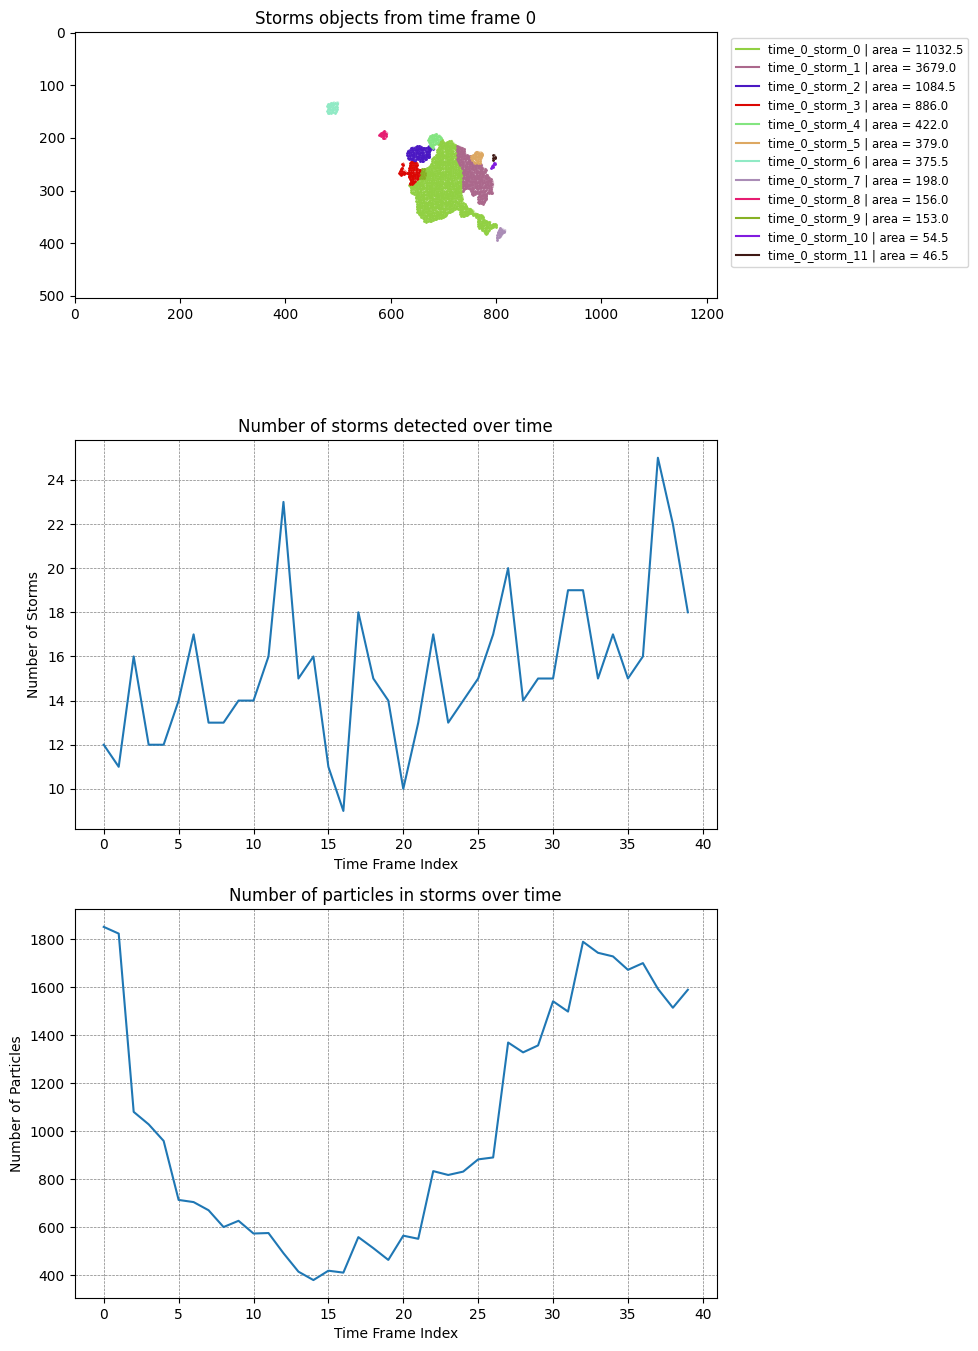

In [5]:
identifier = ClusterIdentifier()
storms_map_time_lst: list[DbzStormsMap] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    contours = identifier.identify_storm(dbz_map, thresholds=THRESHOLDS, filter_center=FILTER_CENTER, filter_area=FILTER_AREA)
     # convert contours to polygons and sort by area
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")

    # Keep list of storms
    storms = []

    for idx, polygon in enumerate(polygons):
        contour = convert_polygons_to_contours([polygon])[0]

        # Create the mask of current storm
        mask = np.zeros_like(dbz_map, dtype=np.uint8)
        cv2.fillPoly(mask, contour, color=1)

        # Extract DBZ values inside mask
        weights = dbz_map * mask

        # Create coordinate grids
        y_idx, x_idx = np.indices(dbz_map.shape)

        # Compute weighted centroid
        total_weight = weights.sum()
        if total_weight == 0:
            centroid = (np.nan, np.nan)  # or fallback
        else:
            cx = (x_idx * weights).sum() / total_weight
            cy = (y_idx * weights).sum() / total_weight
            centroid = (int(cx), int(cy))

        storms.append(ParticleStorm(
                polygon, centroid=centroid, id=f"time_{time_idx}_storm_{idx}", density=DENSITY
            ))
        
    storms_map = DbzStormsMap(storms, time_frame=time_frame)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(10, 14))

plt.subplot(3,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in storms_map_time_lst[0].storms:
    color = np.random.randint(0, 255, size=3).tolist()
    x_centroid, y_centroid = storm.centroid
    particles = storm.particles
    x_points, y_points = particles[:, 1], particles[:, 0]
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_points, y_points, color=np.array(color)/255.0, s=1)
    # plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

plt.legend(loc="upper right", fontsize='small', ncol=1, bbox_to_anchor=(1.4, 1))
plt.imshow(blank_image,cmap="gray")
plt.title('Storms objects from time frame 0')
plt.tight_layout()


plt.subplot(3,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.tight_layout()

plt.subplot(3,1,3)
number_of_storms = [np.sum([storm.get_num_particles() for storm in storms_map.storms]) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of particles in storms over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Particles')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.tight_layout()
plt.show()

In [6]:
# try initial guess using TREC estimation
prev_idx = 0
curr_idx = 1
dt = (storms_map_time_lst[curr_idx].time_frame - storms_map_time_lst[prev_idx].time_frame).total_seconds() / 3600.0
vy, vx, block_size = storms_map_time_lst[prev_idx].trec_estimate(dbz_map_1=dbz_maps[prev_idx],dbz_map_2=dbz_maps[curr_idx], dt=dt)

for storm in storms_map_time_lst[prev_idx].storms:
    dy, dx = storm.estimated_velocity
    print(f"Storm ID: {storm.id} | Estimated velocity (dy, dx): ({dy:.2f}, {dx:.2f}) | Number of particles: {storm.get_num_particles()}")

vy, vx, block_size

Storm ID: time_0_storm_0 | Estimated velocity (dy, dx): (9.68, -26.59) | Number of particles: 1104
Storm ID: time_0_storm_1 | Estimated velocity (dy, dx): (-12.91, -7.15) | Number of particles: 368
Storm ID: time_0_storm_2 | Estimated velocity (dy, dx): (36.61, -53.12) | Number of particles: 109
Storm ID: time_0_storm_3 | Estimated velocity (dy, dx): (-43.03, -53.15) | Number of particles: 89
Storm ID: time_0_storm_4 | Estimated velocity (dy, dx): (60.47, -76.51) | Number of particles: 43
Storm ID: time_0_storm_5 | Estimated velocity (dy, dx): (-1.58, -22.89) | Number of particles: 38
Storm ID: time_0_storm_6 | Estimated velocity (dy, dx): (-18.95, -24.74) | Number of particles: 38
Storm ID: time_0_storm_7 | Estimated velocity (dy, dx): (84.50, -90.50) | Number of particles: 20
Storm ID: time_0_storm_8 | Estimated velocity (dy, dx): (-179.38, -285.00) | Number of particles: 16
Storm ID: time_0_storm_9 | Estimated velocity (dy, dx): (-1.88, -11.88) | Number of particles: 16
Storm ID: ti

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(31, 76)),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(31, 76)),
 16)

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Idea**:

    + Match 1-one-1 between 2 lists of particles.    
    + Count number of corresponding particles matching between 2 storms.
    + Construct 2 probabilites matrices.
    + Soft matching between 2 lists of storms.

- **class** $\textcolor{orange}{\text{ParticleMatcher}}$: make one-to-one assignments between particle in $t$ and $t+1$. The disparity matrix is constructed as follow:

    + **Input**: An estimated vector for each particle at time $t$: $V_t$
    + Construct the displacement matrix: 
        $$V'_{t+1}{i,j} = \frac{p_{t+1}(j)-p_t(i)}{dt}$$
    + Penalty terms for changes in direction of movement:
        $$T_D = 1 - \frac{V_t * V'_{t+1}}{\left\|V_t\right\|\left\|V'_{t+1}\right\|}$$
    + Penalty terms for changes in speed:
        $$T_S = 1 - \frac{2\sqrt{\Delta_{max} * S}}{\Delta_{max} + S}$$
        where $S = \max{(\Delta_{max} - \left|V'_{t+1}-V_t\right|, 0)}$
    + Cost function:
        $$C = w_D * T_D + w_S * T_S$$
    
    + **Penalty terms for constraint violation**: any entry with either $T_D >= 1$ or $T_S == 1$ will be set to infinity.

- **class** $\textcolor{ForestGreen}{\text{StormMatcher}}$: make a soft assignment between 2 storms, from the disparity matrix that is constructed from probability of particle matching between each pair of storms

In [7]:
from src.tracking import BaseMatcher, BaseTrackingHistory, BaseTracker, reduced_soft_hungarian
from dataclasses import dataclass

@dataclass
class Particle:
    position: np.ndarray
    storm_order: int        # order of the storm this particle belongs to

class ParticleMatcher(BaseMatcher):
    def _construct_disparity_matrix(
            self, particle_lst1: list[Particle], particle_lst2: list[Particle], estimated_vectors: np.ndarray, 
            weights: list[float], max_displacement: float
        ):
        """
        Construct a disparity matrix for 2 lists of particles.

        Parameters:
            particle_lst1 (list[Particle]): The first list of particles.
            particle_lst2 (list[Particle]): The second list of particles.
            estimated_vectors (np.ndarray): The estimated movement vectors for each particle in `particle_lst1`.
            weights (list[float]): the list of nonnegative- and sum-to-1 weights.

        Returns:
            cost_matrix, T_D, T_S (tuple[np.ndarray, np.ndarray]): The constructed disparity matrix and distance matrix for later verification.
        """
        # print(f"ParticleMatcher weights: {weights}")
        assert all([all([w >= 0 for w in weights]), np.sum(weights) == 1]), "weights must not be negative and must sum to 1."
        n2 = len(particle_lst2)
        coord_1 = np.array([p.position for p in particle_lst1])
        coord_2 = np.array([p.position for p in particle_lst2])

        displacement_matrix = coord_1[:, np.newaxis, :] - coord_2[np.newaxis, :, :]         # shape: (n1, n2, 2)
        estimated_matrix = np.repeat(estimated_vectors[:, np.newaxis, :], n2, axis=1)       # shape: (n1, n2, 2)

        # compute T_D
        dot_product = np.sum(displacement_matrix * estimated_matrix, axis=-1)  # (n1, n2)
        norms = (np.linalg.norm(displacement_matrix, axis=-1) *
                    np.linalg.norm(estimated_matrix, axis=-1) + 1e-8)
        T_D = 1 - dot_product / norms   # shape: (n1, n2)
        
        # compute T_S
        norm_displ_matrix = np.linalg.norm(displacement_matrix - estimated_matrix, axis=-1)       # shape: (n1, n2)
        max_diff_matrix = np.clip(max_displacement - norm_displ_matrix, a_min=0, a_max=max_displacement)
        T_S = 1 - (2 * np.sqrt(max_displacement * max_diff_matrix)) / (max_displacement + max_diff_matrix + 1e-6)   # shape: (n1, n2)

        # compute cost matrix
        cost_matrix = weights[0] * T_D + weights[1] * T_S

        return cost_matrix, T_D, T_S
    
    def match_particles(
            self, particle_lst1: list[Particle], particle_lst2: list[Particle], estimated_vectors: np.ndarray, 
            maximum_displacement: float, weights: list[float] = [0.5, 0.5]
        ) -> np.ndarray:
        """
        Match particles between 2 lists of particles.
        Parameters:
            particle_lst1 (list[Particle]): The first list of particles.
            particle_lst2 (list[Particle]): The second list of particles.
            maximum_displacement (float): The maximum displacement allowed for a particle to be considered a match.
            weights (list[float], default=[0.5, 0.5]): the list of nonnegative- and sum-to-1 weights.
        Returns:
            assignments (np.ndarray): The array of matched indices between the 2 lists of particles.
        """
        # print(f"ParticleMatcher weights: {weights}")
        cost_matrix, T_D, T_S = self._construct_disparity_matrix(
            particle_lst1, particle_lst2, estimated_vectors=estimated_vectors, 
            max_displacement=maximum_displacement, weights=weights
        )
        invalid_mask = (T_D >= 1) & (T_S >= 1)
        cost_matrix[invalid_mask] = 3000

        row_ind, col_ind = self._hungarian_matching(cost_matrix)
        assignment_mask = np.zeros_like(invalid_mask, dtype=bool)
        assignment_mask[row_ind, col_ind] = True

        return np.argwhere(assignment_mask & np.logical_not(invalid_mask))

@dataclass
class CellSubset:
    sources: set[int]      # list of indices of source storms
    targets: set[int]      # list of indices of target storms

    def add_cell(self, source: int = None, target: int = None):
        """
        add a source/target storm index to the subcell.
        """
        if source is not None:
            self.sources.add(source)
        if target is not None:
            self.targets.add(target)
    
    def merge_subcell(self, other: "CellSubset"):
        """
        merge another subcell into this one.
        """
        self.sources = self.sources.union(other.sources)
        self.targets = self.targets.union(other.targets)

    def contains(self, storm_order: int, is_source: bool=True) -> bool:
        """
        check if the cell contains the given source/target storm index.
        """
        return (storm_order in self.sources) if is_source else (storm_order in self.targets)
    
class SubsetResolver:
    matching_threshold: float

    def __init__(self, matching_threshold: float):
        self.matching_threshold = matching_threshold

    def create_subsets(self, assignments: list[tuple[int, int]]) -> list[CellSubset]:
        """
        create subsets of storms based on the assignments between 2 time frames.
        """
        subcells: list[CellSubset] = []

        for prev_idx, curr_idx in assignments:
            prev_subcell = None
            curr_subcell = None

            # find if there is existing subcell containing prev_idx or curr_idx
            for subcell in subcells:
                if subcell.contains(prev_idx, is_source=True):
                    prev_subcell = subcell
                if subcell.contains(curr_idx, is_source=False):
                    curr_subcell = subcell
            
            # case 1: both are not belonged to any subcell => create new subcell
            if not prev_subcell and not curr_subcell:
                # create new subcell
                new_subcell = CellSubset(sources={prev_idx}, targets={curr_idx})
                subcells.append(new_subcell)
                continue
                
            # case 2: only one of them is belonged to a subcell => add the other index to that subcell
            if prev_subcell and not curr_subcell:
                prev_subcell.add_cell(target=curr_idx)
                continue
            if not prev_subcell and curr_subcell:
                curr_subcell.add_cell(source=prev_idx)
                continue
                
            # case 3: both are belonged to different subcells => merge the 2 subcells
            if prev_subcell != curr_subcell:
                prev_subcell.merge_subcell(curr_subcell)
                subcells.remove(curr_subcell)
        
        return subcells

    def resolve_subsets(
            self, subset_lst: list[CellSubset], storms_map_lst_1: DbzStormsMap, storms_map_lst_2: DbzStormsMap, max_velocity: float, weights: list[float] = [0.5, 0.5]
        ) -> list[tuple[int, int]]:
        """
        resolve the subset to get final assignments between 2 time frames.
        """
        # compute maximum displacement
        dt = (storms_map_lst_1.time_frame - storms_map_lst_2.time_frame).total_seconds() / 3600.0
        maximum_displacement = max_velocity * dt
        particles_matcher = ParticleMatcher()

        final_subset_lst: list[CellSubset] = []

        for subset in subset_lst:
            prev_storms_lst: list[tuple[int, ParticleStorm]] = [(idx, storm) for idx, storm in enumerate(storms_map_lst_1.storms) if idx in subset.sources]
            curr_storms_lst: list[tuple[int, ParticleStorm]] = [(idx, storm) for idx, storm in enumerate(storms_map_lst_2.storms) if idx in subset.targets]

            particles_prev: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in prev_storms_lst for particle in storm.particles]
            particles_curr: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in curr_storms_lst for particle in storm.particles]

            estimated_vectors = np.array([storm.estimated_velocity for _, storm in prev_storms_lst for _ in storm.particles]) * dt     # scale to the time difference

            # match particles
            particle_assignments = particles_matcher.match_particles(
                particles_prev, particles_curr, estimated_vectors, maximum_displacement, weights
            )

            # count number of matched particles between each pair of storms
            matching_count = np.zeros((len(storms_map_lst_1.storms), len(storms_map_lst_2.storms)), dtype=np.int64)

            for idx1, idx2 in particle_assignments:
                matching_count[particles_prev[idx1].storm_order, particles_curr[idx2].storm_order] += 1
            
            # compute probability matrix
            ## p_A: Probability of matching where the denominator is the number of particles in the previous storm
            ## p_B: Probability of matching where the denominator is the number of particles in the curr storm
            p_A = matching_count / np.array([len(storm.particles) for storm in storms_map_lst_1.storms])[:, np.newaxis]
            p_B = matching_count / np.array([len(storm.particles) for storm in storms_map_lst_2.storms])[np.newaxis, :]

            p = np.max([p_A, p_B], axis=0)
            assignments = np.argwhere(p >= 0.5)

            prev_storm_indices = assignments[:, 0].tolist()
            curr_storm_indices = assignments[:, 1].tolist()

            final_subset_lst.append(CellSubset(sources=set(prev_storm_indices), targets=set(curr_storm_indices)))
        
        return final_subset_lst

class StormMatcher(BaseMatcher):
    particles_matcher: ParticleMatcher
    subset_resolver: SubsetResolver
    max_velocity: float
    weights: list[float]                    # weights for distance and shape

    def __init__(self, max_velocity: float, matching_threshold: float, weights: list[float] = [0.5, 0.5]):
        super().__init__()
        self.particles_matcher = ParticleMatcher()
        self.max_velocity = max_velocity
        self.subset_resolver = SubsetResolver(matching_threshold=matching_threshold)
        self.weights = weights

    def _construct_disparity_matrix(
            self, storms_lst1: list[ParticleStorm], storms_lst2: list[ParticleStorm]
        ):
        pass

    def match_storms(
            self, storms_map_lst_1: DbzStormsMap, storms_map_lst_2: DbzStormsMap
        ) -> list[CellSubset]:
        """
        Match storms between 2 time frame.
        
        Args:
            storms_lst_1 (list[ParticleStorm]): The list of storms at time t.
            storms_lst_2 (list[ParticleStorm]): The list of storms at time t+1.

        Returns:
            subset_assignments (list[CellSubset]): The list of matched storm subsets between the 2 time frames.
        """
        # get particles lists for both time frames
        particles_prev: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in enumerate(storms_map_lst_1.storms) for particle in storm.particles]
        particles_curr: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in enumerate(storms_map_lst_2.storms) for particle in storm.particles]

        # compute maximum displacement
        dt = (storms_map_lst_1.time_frame - storms_map_lst_2.time_frame).total_seconds() / 3600.0
        maximum_displacement = self.max_velocity * dt
        estimated_vectors = np.array([storm.estimated_velocity for storm in storms_map_lst_1.storms for _ in storm.particles]) * dt     # scale to the time difference

        # match particles
        particle_assignments = self.particles_matcher.match_particles(
            particles_prev, particles_curr, estimated_vectors, maximum_displacement, self.weights
        )

        # count number of matched particles between each pair of storms
        matching_count = np.zeros((len(storms_map_lst_1.storms), len(storms_map_lst_2.storms)), dtype=np.int64)

        for idx1, idx2 in particle_assignments:
            matching_count[particles_prev[idx1].storm_order, particles_curr[idx2].storm_order] += 1

        # return matching_count
        
        # compute probability matrix
        ## p_A: Probability of matching where the denominator is the number of particles in the previous storm
        ## p_B: Probability of matching where the denominator is the number of particles in the curr storm
        p_A = matching_count / np.array([len(storm.particles) for storm in storms_map_lst_1.storms])[:, np.newaxis]
        p_B = matching_count / np.array([len(storm.particles) for storm in storms_map_lst_2.storms])[np.newaxis, :]

        # find the soft-hungarian assignment
        assignments_A = reduced_soft_hungarian(1 - p_A)
        assignments_B = reduced_soft_hungarian(1 - p_B)
        assignments = list(set(assignments_A).union(set(assignments_B)))

        subsets = self.subset_resolver.create_subsets(assignments)
        resolved_subsets = self.subset_resolver.resolve_subsets(
            subsets, storms_map_lst_1, storms_map_lst_2, self.max_velocity, self.weights
        )

        return resolved_subsets

In [8]:
MAX_VELOCITY = 500          # in km/h
MATCHING_THRESHOLD = 0.5    # minimum probability threshold for matching between 2 storms
WEIGHTS = [0.5, 0.5]        # weights for T_S and T_D

matcher = StormMatcher(max_velocity=MAX_VELOCITY, matching_threshold=MATCHING_THRESHOLD)
subsets = matcher.match_storms(
    storms_map_lst_1=storms_map_time_lst[0], storms_map_lst_2=storms_map_time_lst[1]
)

print(f"-- Subset assignments --")
for subset in subsets:
    print(f"\tSources: {subset.sources}, Targets: {subset.targets}")

-- Subset assignments --
	Sources: {0, 1, 2, 3, 4, 5, 7, 8, 9, 10}, Targets: {0, 1, 2, 3, 4, 5, 7, 8, 9}
	Sources: {11}, Targets: {10}


### 2.2 Implemetation of `TrackingHistory`

In [9]:
from copy import deepcopy

class TrackingHistory(BaseTrackingHistory):
    def __init__(self, storms_map: StormsMap):
        self.tracks = [self._initialize_track(storm, storms_map.time_frame) for storm in storms_map.storms]
        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.storm_dict)))
    
    def _initialize_track(self, storm: ParticleStorm, time_frame: datetime):
        return {"storm_lst": [storm], "frame": [time_frame], "movement": []}

    def _copy_track(self, track: dict) -> dict:
        pass

    def _get_track(self, storm_id: str) -> tuple[dict, bool]:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track, is_active (tuple[dict, bool]): the track of the storm and whether it is active.
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm {storm_id} not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id], track_id in self.active_list

    def _interpolate_velocity(self, velocity_lst: list[np.ndarray], alpha_decay: float = 0.5) -> np.ndarray:
        """
        Interpolate the velocity using weighted average with decay factor alpha_decay.

        Args:
            velocity_lst (list[np.ndarray]): list of velocity vectors.
            alpha_decay (float, default=0.5): the decay factor.

        Returns:
            interpolated_velocity (np.ndarray): the interpolated velocity.
        """
        if len(velocity_lst) == 1:
            return velocity_lst[0]
        
        weights = np.array([alpha_decay**i for i in range(len(velocity_lst))])
        total_w = np.sum(weights)
        try:
            return np.sum([np.array(displ) * w / total_w for displ, w in zip(velocity_lst[::-1], weights)], axis=0)
        except Exception as e:
            print(f"Error in _interpolate_velocity:\n{weights}\n{velocity_lst}")
            raise e

    def _get_centroid(self, storms: list[ParticleStorm]) -> np.ndarray:
        """
        Get the centroids of the list of storms.

        Args:
            storms (list[ParticleStorm]): the list of storms.

        Returns:
            centroids (np.ndarray): the array of centroids.
        """
        centroids = np.array([storm.centroid for storm in storms])
        areas = np.array([storm.contour.area for storm in storms])
        weights = areas / np.sum(areas)

        return np.average(centroids, weights=weights, axis=0)

    def _combine_histories(self, merge_lst: list[dict]) -> list[np.ndarray]:
        """
        Combine the histories of multiple tracks into a single history of velocities.

        Args:
            merge_lst (list[dict]): list of tracks to be merged.

        Returns:
            combined_history (list[np.ndarray]): the combined list of velocity vectors over time.
        """
        weights = np.array([s["area"] for s in merge_lst])
        movements_lst = [np.array(s["movement"])[::-1] for s in merge_lst]  # revert for matching the time.

        combined_len = max([len(movements) for movements in movements_lst]) # length of parent = max length of its child
        parent_movement = np.zeros(shape=(combined_len, 2), dtype=np.float64)

        # for each time, if the
        for i in range(combined_len):
            total_value, total_weight = np.zeros(shape=(2,)), 0
            for weight, movements in zip(weights, movements_lst):
                if len(movements) <= i:
                    continue
                total_value += movements[i]
                total_weight += weight
            parent_movement[i] = total_value / total_weight
        
        return parent_movement[::-1].tolist()
    
    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> ParticleStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history. Unit: pixel/hr.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track, status = self._get_track(storm_id)
        if not status:
            print(f"⚠️ Storm has been expired")
        
        curr_storm: ParticleStorm = track["storm_lst"][-1]
        velocity_lst = track["movement"]
        if len(velocity_lst) == 0:
            dx, dy = default_motion * dt
        else:
            dx, dy = self._interpolate_velocity(velocity_lst) * dt

        new_storm = curr_storm.copy()
        new_storm.make_move(np.array([dx, dy]))

        return new_storm

    def update(
            self, subset_assignments: list[CellSubset], prev_storms_map: DbzStormsMap, curr_storms_map: DbzStormsMap, **kargs
        ):
        """
        Update the tracking history with new assignments and storms map.

        Args:
            subset_assignments (list[CellSubset]): list of subset assignments between previous and current storms maps.
            storms_map (StormsMap): the current storms map.
        """
        vy, vx, block_size = kargs.get("trec_params", (None, None, None))

        active_lst = []
        curr_time = curr_storms_map.time_frame
        prev_time = prev_storms_map.time_frame

        dt = (curr_time - prev_time).seconds / 3600

        def get_movement(subset: CellSubset) -> np.ndarray:
            """
            Get the movement vector for the subset.
            """
            prev_centroids = self._get_centroid([prev_storms_map.storms[idx] for idx in subset.sources])
            curr_centroids = self._get_centroid([curr_storms_map.storms[idx] for idx in subset.targets])
            return (curr_centroids - prev_centroids) / dt    # in pixel/hr

        for subset in subset_assignments:
            # case 1: no previous matching => create a new track
            if len(subset.sources) == 0:
                curr_storm = curr_storms_map.storms[list(subset.targets)[0]]
                curr_storm.assign_trec_movement(vy, vx, block_size)
                
                # create a new track
                self.tracks.append(self._initialize_track(curr_storm, curr_time))

                # update storm dict and active_lst
                new_tid = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_tid
                active_lst.append(new_tid)

            # case 2: one-to-one matching => update the existing track
            elif len(subset.targets) == 1 and len(subset.sources) == 1:    
                velocity_vector = get_movement(subset)
                prev_storm = prev_storms_map.storms[list(subset.sources)[0]]
                curr_storm = curr_storms_map.storms[list(subset.targets)[0]]
                curr_storm.estimated_velocity = velocity_vector

                track, _ = self._get_track(prev_storm.id)

                track["storm_lst"].append(curr_storm)
                track["frame"].append(curr_time)
                track["movement"].append(velocity_vector)
                active_lst.append(self.storm_dict[prev_storm.id])
                self.storm_dict[curr_storm.id] = self.storm_dict[prev_storm.id]
            
            # case 3: one-to-many or many-to-one or many-to-many matching => create new tracks for target storms
            else:
                velocity_vector = get_movement(subset)
                
                # create a combined history from all source storms
                merge_lst = []
                combine_frames_history = []
                combine_storms_history = []

                for prev_idx in subset.sources:
                    prev_storm = prev_storms_map.storms[prev_idx]
                    track, _ = self._get_track(prev_storm.id)

                    if len(track["frame"]) > len(combine_frames_history):
                        combine_frames_history = deepcopy(track["frame"])
                        combine_storms_history = deepcopy(track["storm_lst"])

                    merge_lst.append({"movement": track["movement"], "area": prev_storm.contour.area})
                
                combine_frames_history.append(curr_time)
                combined_movements_history = self._combine_histories(merge_lst) + [velocity_vector]

                # update target storms
                for curr_idx in subset.targets:
                    curr_storm = curr_storms_map.storms[curr_idx]
                    curr_storm.estimated_velocity = velocity_vector
                    # create a new track
                    new_track = {
                        "storm_lst": combine_storms_history + [curr_storm],
                        "frame": deepcopy(combine_frames_history),
                        "movement": deepcopy(combined_movements_history)
                    }

                    # update storm dict and active_lst
                    self.tracks.append(new_track)
                    new_tid = len(self.tracks) - 1
                    self.storm_dict[curr_storm.id] = new_tid
                    active_lst.append(new_tid)

        self.active_list = active_lst

    def print_tracks(self, active_only: bool = False):
        for id, track in enumerate(self.tracks):
            if active_only and id not in self.active_list:
                continue
            print(f"Track {id:2d}. " + " -> ".join(storm.id for storm in track["storm_lst"]))
            print(f"Lifespan: {len(track["frame"])}")
            print(f"Last track: {track["frame"][-1].strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

In [10]:
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class Tracker(BaseTracker):
    matcher: StormMatcher
    tracker: TrackingHistory

    def __init__(self, max_velocity: float, matching_threshold: float, weights: list[float] = [0.5, 0.5]):
        self.matcher = StormMatcher(max_velocity, matching_threshold, weights)

    def fit(self, storms_map_time_lst: list[DbzStormsMap], test=False, **kargs):
        """
        Fit the tracker on the list of storms maps over time.
        Args:
            storms_map_time_lst (list[DbzStormsMap]): list of storms maps over time.
            test (bool, default=False): whether to compute the metrics during fitting.
        """
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        trec_params = kargs.get("trec_params", None)

        for idx in range(0, len(storms_map_time_lst)-1):
            # get the current maps
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).total_seconds() / 3600.0

            if test:
                pred_storms_map = DbzStormsMap(
                    storms=[self.tracker.forecast(storm.id, dt=dt) for storm in prev_storms_map.storms],
                    time_frame=curr_storms_map.time_frame
                )
                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            # get the subset assignments
            subset_assignments = self.matcher.match_storms(prev_storms_map, curr_storms_map)

            # create an empty unassigned storms
            curr_assigned_indices = [idx for subset in subset_assignments for idx in subset.targets]
            curr_unassigned_indices = [idx for idx in range(len(curr_storms_map.storms)) if idx not in curr_assigned_indices]
            for idx in curr_unassigned_indices:
                subset_assignments.append(CellSubset(sources=set(), targets={idx}))

            self.tracker.update(subset_assignments, prev_storms_map, curr_storms_map, trec_params=trec_params)

        if test:
            return csi_scores, far_scores, pod_scores, frames
    
    def predict(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> ParticleStorm:
        try:
            return self.tracker.forecast(storm_id, dt, default_motion)
        except KeyError:
            print(f"❗ Storm not found on the track. `None` will be returned.")
            return None

In [11]:
MAX_VELOCITY = 500          # in km/h
MATCHING_THRESHOLD = 0.5    # minimum probability threshold for matching between 2 storms
WEIGHTS = [0.5, 0.5]        # weights for T_S and T_D

tracker = Tracker(max_velocity=MAX_VELOCITY, matching_threshold=MATCHING_THRESHOLD, weights=WEIGHTS)
csi_scores, far_scores, pod_scores, frames = tracker.fit(storms_map_time_lst, test=True, trec_params=(vy, vx, block_size))

tracker.tracker.print_tracks(active_only=True)

Track 533. time_0_storm_0 -> time_1_storm_0 -> time_2_storm_0 -> time_3_storm_0 -> time_4_storm_0 -> time_5_storm_0 -> time_6_storm_0 -> time_7_storm_0 -> time_8_storm_0 -> time_9_storm_0 -> time_10_storm_0 -> time_11_storm_0 -> time_12_storm_1 -> time_13_storm_0 -> time_14_storm_0 -> time_15_storm_0 -> time_16_storm_0 -> time_17_storm_0 -> time_18_storm_0 -> time_19_storm_0 -> time_20_storm_0 -> time_21_storm_0 -> time_22_storm_1 -> time_23_storm_0 -> time_24_storm_0 -> time_25_storm_0 -> time_26_storm_0 -> time_27_storm_0 -> time_28_storm_0 -> time_29_storm_0 -> time_30_storm_0 -> time_31_storm_0 -> time_32_storm_0 -> time_33_storm_0 -> time_34_storm_0 -> time_35_storm_0 -> time_36_storm_0 -> time_37_storm_0 -> time_38_storm_3 -> time_39_storm_4
Lifespan: 40
Last track: 2025-01-08 07:04:54
--------------------------------------------------
Track 535. time_0_storm_0 -> time_1_storm_0 -> time_2_storm_0 -> time_3_storm_0 -> time_4_storm_0 -> time_5_storm_0 -> time_6_storm_0 -> time_7_st

## 3. Nowcasting

Compare **Naive** (keep the storms without moving) vs. the current method

In [12]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9217 | FAR: 0.0925 | CSI: 0.8425
	Time 2025-01-08 03:22:45 | POD: 0.7963 | FAR: 0.5302 | CSI: 0.4194
	Time 2025-01-08 03:28:45 | POD: 0.8781 | FAR: 0.1633 | CSI: 0.7497
	Time 2025-01-08 03:34:45 | POD: 0.8875 | FAR: 0.1720 | CSI: 0.7494
	Time 2025-01-08 03:40:45 | POD: 0.6780 | FAR: 0.4975 | CSI: 0.4057
	Time 2025-01-08 03:46:46 | POD: 0.8721 | FAR: 0.1415 | CSI: 0.7625
	Time 2025-01-08 03:52:46 | POD: 0.4462 | FAR: 0.5745 | CSI: 0.2785
	Time 2025-01-08 03:58:46 | POD: 0.8372 | FAR: 0.2472 | CSI: 0.6566
	Time 2025-01-08 04:04:46 | POD: 0.7749 | FAR: 0.1951 | CSI: 0.6523
	Time 2025-01-08 04:10:47 | POD: 0.7003 | FAR: 0.3600 | CSI: 0.5024
	Time 2025-01-08 04:16:47 | POD: 0.8385 | FAR: 0.1606 | CSI: 0.7226
	Time 2025-01-08 04:22:47 | POD: 0.4129 | FAR: 0.6511 | CSI: 0.2332
	Time 2025-01-08 04:28:47 | POD: 0.7191 | FAR: 0.3869 | CSI: 0.4946
	Time 2025-01-08 04:34:48 | 

In [13]:
storm = storms_map_time_lst[1].storms[0]
tracker.predict(storm.id, dt=0.1)      # 0.1 hr = 6 minutes

⚠️ Storm has been expired


ParticleStorm(contour=<POLYGON ((704.307 214.716, 695.307 223.716, 694.307 223.716, 693.307 224.71...>, id='pred_time_1_storm_0')

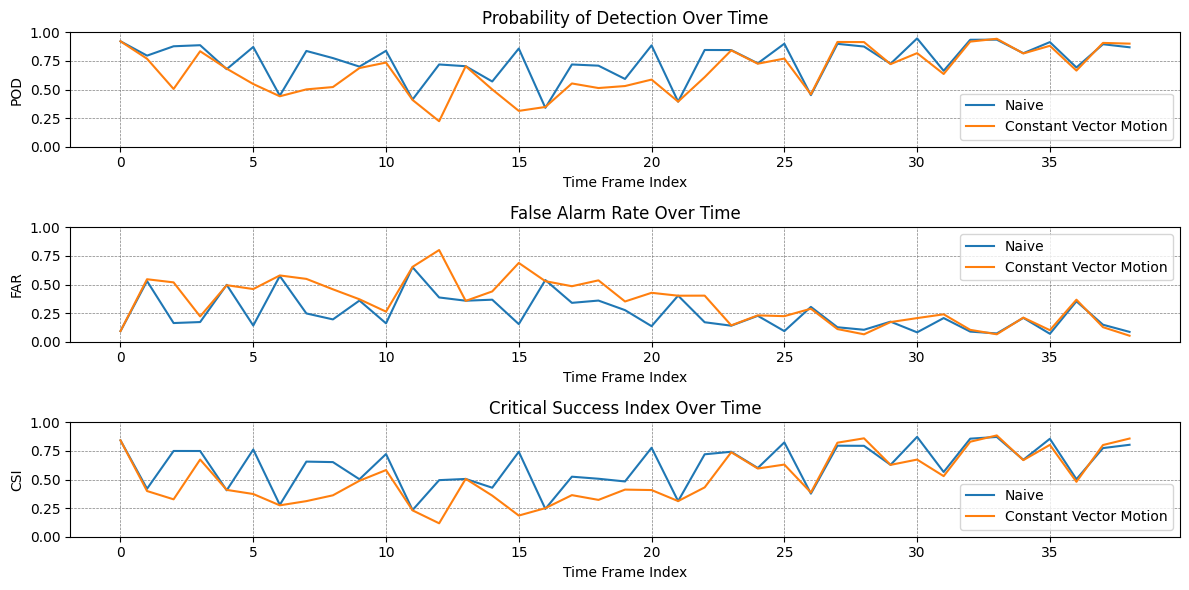

In [14]:
indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, pod_scores), 
    (bm_far_scores, far_scores),
    (bm_csi_scores, csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()